In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

import cv2

#Per data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

import time
import math
import statistics

import operator

from collections import defaultdict

print(tf.__version__)

1.15.2


In [3]:
#Extract the full file name
def extract_name(from_string):
  to_pos = from_string.index('.')
  substring = from_string[0:to_pos]
  return substring

In [4]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

import Defining_Methods as my_lib

Cloning into 'NN_modules'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 63 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1z5J7XE_KJYzZGJd-NHX8PUggED2ZK8HG"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.zip')        # replace the file name with your file

!unzip -q data.zip -d DB_Repo/

path, dirs, files = next(os.walk("/content/DB_Repo/data"))
file_count = len(files)
#Should be 14100
print(file_count)

%cd /content/DB_Repo/data
!pwd

print("Done")

14100
/content/DB_Repo/data
/content/DB_Repo/data
Done


In [7]:
#COSTANTI E DICHIARAZIONI

database_list = list()
filename_list = list()
labels_list = list()
obf_list = list()
class_names = set()

#LETTURA E RESIZE IMMAGINI

#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  database_list.append(temp_img)
  #Salvo il file name
  filename_list.append(extract_name(filename))
  #Salvo la label, ossia la classe
  labels_list.append(my_lib.extract_label(filename))
  #Creo un set di tutte le classi così trovate
  class_names.add(my_lib.extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(my_lib.extract_obf(filename))

In [8]:
'''

#SHUFFLE

#Ho i valori e le etichette in due liste (+ obf); 
#le mescolo mantenendo l'ordine tra valore-label
temp = list(zip(database_list, labels_list, obf_list))
np.random.shuffle(temp)
database_list, labels_list, obf_list = zip(*temp)


'''

"\n\n#SHUFFLE\n\n#Ho i valori e le etichette in due liste (+ obf); \n#le mescolo mantenendo l'ordine tra valore-label\ntemp = list(zip(database_list, labels_list, obf_list))\nnp.random.shuffle(temp)\ndatabase_list, labels_list, obf_list = zip(*temp)\n\n\n"

In [9]:
assert len(database_list) == len(labels_list) == len(obf_list)

#Trasformo i valori in numpy.ndarray
images = np.array(database_list)

labels = np.array(labels_list)

obf = np.array(obf_list)

numero_file = images.size

#ANALISI DATABASE

In [10]:
print("Numero immagini:", images.size)
print("Numero labels:", labels.size)
print("Numero obf:", obf.size)

Numero immagini: 14100
Numero labels: 14100
Numero obf: 14100


In [11]:
dim1, dim2 = images[0].shape
print(dim1, dim2)

11 64


In [12]:
np.amax(images[0])

65535

In [13]:
dim1_min = 999999
dim2_min = 999999
dim1_max = 0
dim2_max = 0
max_val = 0
min_val = 999999

index_of_maxlen = -1

dim2diff = 999999

count_0_1024 = 0
count_1024_2048 = 0
count_2048_4096 = 0
count_over_4096 = 0
count_err = 0

valore_medio_sotto_1024 = 0
#NB se non è esattamente 65535.0, qualche immagine non ha tale valore come massimo
valore_max_medio = 0

lista_obf_dim = list()
dizionario_dim_obf = dict()

for index in range(images.size):
  dim1_t, dim2_t = images[index].shape

  valore_max_medio += np.amax(images[index])

  dizionario_dim_obf[index] = dim1_t

  if max_val < np.amax(images[index]):
    max_val = np.amax(images[index])
  if min_val > np.amax(images[index]):
    min_val = np.amin(images[index])
  if dim1_t > dim1_max:
    dim1_max = dim1_t
    index_of_maxlen = index
  if dim2_t > dim2_max:
    dim2_max = dim2_t
  if dim1_t < dim1_min:
    dim1_min = dim1_t
  if dim2_t < dim2_min:
    dim2_min = dim2_t
  if dim2_t != 64:
    dim2diff = dim2_t

  if dim1_t <= 1024:
    count_0_1024+=1
    valore_medio_sotto_1024 += dim1_t
  elif dim1_t > 1024 and dim1_t <= 2048:
    count_1024_2048+=1
  elif dim1_t > 2048 and dim1_t <= 4096:
    count_2048_4096+=1
  elif dim1_t > 4096:
    count_over_4096+=1
  else:
    count_err+=1

In [14]:
valore_medio_sotto_1024 /= count_0_1024
valore_max_medio /= numero_file

sorted_diz = dict(sorted(dizionario_dim_obf.items(), key=operator.itemgetter(1),reverse=True))

In [15]:
print("Valore più alto:", max_val)
print("Valore più basso:", min_val)
print("Dim1_min:", dim1_min)
print("Dim1_max:", dim1_max)
print("File più lungo:", labels[index_of_maxlen], ",", obf[index_of_maxlen])
print("Dim2_min:", dim2_min)
print("Dim2_max:", dim2_max)
print("Se esiste un valore di dim2 diverso da 64:", dim2diff)
print()
print("Numero dimensioni1 tra 0 e 1024:", count_0_1024)
print("Valore medio dimensioni1 sotto 1024:", valore_medio_sotto_1024)
print("Numero dimensioni1 tra 1024 e 2048:", count_1024_2048)
print("Numero dimensioni1 tra 2048 e 4096:", count_2048_4096)
print("Numero dimensioni1 oltre il 4096:", count_over_4096)
print("Errori nel contare:", count_err)
print()
print("Controllo che il massimo di ogni immagine sia uguale per tutte (ossia 65535):", valore_max_medio)

Valore più alto: 65535
Valore più basso: 0
Dim1_min: 7
Dim1_max: 7912
File più lungo: fair_warning , InitOpaque-EncodeLiterals-RandomFuns
Dim2_min: 64
Dim2_max: 64
Se esiste un valore di dim2 diverso da 64: 999999

Numero dimensioni1 tra 0 e 1024: 13126
Valore medio dimensioni1 sotto 1024: 74.50952308395551
Numero dimensioni1 tra 1024 e 2048: 77
Numero dimensioni1 tra 2048 e 4096: 299
Numero dimensioni1 oltre il 4096: 598
Errori nel contare: 0

Controllo che il massimo di ogni immagine sia uguale per tutte (ossia 65535): 65535.0


In [16]:
counter = 25
for key in sorted_diz:
  print("Lunghezza:", sorted_diz[key], end=", ")
  print(obf[key], end="\t ---> \t\t")
  print(labels[key])
  counter-=1
  if counter == 0:
    break

Lunghezza: 7912, InitOpaque-EncodeLiterals-RandomFuns	 ---> 		fair_warning
Lunghezza: 7899, InitOpaque-EncodeArithmetic-EncodeLiterals	 ---> 		fair_warning
Lunghezza: 7899, EncodeArithmetic-InitOpaque-EncodeLiterals	 ---> 		fair_warning
Lunghezza: 7898, InitOpaque-EncodeLiterals-EncodeArithmetic	 ---> 		fair_warning
Lunghezza: 7894, RandomFuns-InitOpaque-EncodeLiterals	 ---> 		fair_warning
Lunghezza: 7894, InitOpaque-RandomFuns-EncodeLiterals	 ---> 		fair_warning
Lunghezza: 7894, InitOpaque-Flatten-EncodeLiterals	 ---> 		fair_warning
Lunghezza: 7894, Flatten-InitOpaque-EncodeLiterals	 ---> 		fair_warning
Lunghezza: 7891, EncodeLiterals-InitOpaque-RandomFuns	 ---> 		fair_warning
Lunghezza: 7891, EncodeLiterals-RandomFuns-InitOpaque	 ---> 		fair_warning
Lunghezza: 7891, RandomFuns-EncodeLiterals-InitOpaque	 ---> 		fair_warning
Lunghezza: 7890, InitOpaque-EncodeLiterals-Flatten	 ---> 		fair_warning
Lunghezza: 7889, InitOpaque-EncodeLiterals-Split	 ---> 		fair_warning
Lunghezza: 7887, Enco

In [17]:
classi_e_val = list()

for indice in range(images.size):
  dimensione_classe = images[indice].shape[0]
  classe = labels[indice]
  classi_e_val.append((classe, dimensione_classe))

In [18]:
from itertools import groupby
from operator import itemgetter
from statistics import mean


#s = [('A', 1), ('B', 2), ('C', 3), ('A', 9), ('B', 8)]
s = classi_e_val
s2 = sorted(s, key=itemgetter(0))   # sorting the tuple based on 0th index

dimension_list = [(k, int(mean(list(zip(*g))[1]))) for k, g in groupby(s2, itemgetter(0))]

In [19]:
sorted_by_second = sorted(dimension_list, key=lambda tup: tup[1])

In [20]:
for elem in sorted_by_second:
  print(elem)

('hello_world', 38)
('count_digits', 43)
('pyramid', 43)
('sum', 43)
('times_table', 43)
('factorial_rec', 44)
('factors', 44)
('fib_1', 44)
('reverse_integer', 44)
('strcpy', 44)
('strlen', 44)
('fib_2', 45)
('gcd', 45)
('gcd_rec', 45)
('lcm', 45)
('power_n', 45)
('n_is_palindrome', 46)
('n_is_prime', 46)
('remove_char', 46)
('factorial', 47)
('positive_or_negative', 47)
('prime_n_between_intervals', 47)
('quotient_remainder', 47)
('armstrong_n', 48)
('char_frequency', 48)
('strcat', 48)
('leap_year', 49)
('minimum_scalar_product', 49)
('n_is_sum_of_primes', 49)
('stringsort', 50)
('candy_splitting', 51)
('snapper_chain', 51)
('calculator', 56)
('store_struct', 56)
('count_vowels', 57)
('fly_swatter', 57)
('saving_the_universe', 59)
('train_time_table', 67)
('bot_trust', 84)
('rotate', 84)
('welcome_to_codejam', 121)
('multibase_happiness', 153)
('theme_park', 257)
('watersheds', 997)
('magicka', 3577)
('alien_language', 4546)
('fair_warning', 7778)


In [21]:
obf_set = set()

for index in range(obf.size):
  for elem in obf[index].split('-'):
    obf_set.add(elem)

print("Trasformazioni applicate:")
print(sorted(obf_set))

sorted_obf_set = sorted(obf_set)
counter = 1
for elem in (sorted_obf_set):
  print("{}: {}".format(counter, elem))
  counter += 1

Trasformazioni applicate:
['EncodeArithmetic', 'EncodeLiterals', 'Flatten', 'InitEntropy', 'InitImplicitFlow', 'InitOpaque', 'RandomFuns', 'Split', 'base']
1: EncodeArithmetic
2: EncodeLiterals
3: Flatten
4: InitEntropy
5: InitImplicitFlow
6: InitOpaque
7: RandomFuns
8: Split
9: base


In [22]:
labels_set = set()

for index in range(obf.size):
  for elem in labels[index].split('-'):
    labels_set.add(elem)

print("Programmi (labels) analizzati:")

sorted_labels_set = sorted(labels_set)
counter = 1
for elem in (sorted_labels_set):
  print("{}: {}".format(counter, elem))
  counter += 1

Programmi (labels) analizzati:
1: alien_language
2: armstrong_n
3: bot_trust
4: calculator
5: candy_splitting
6: char_frequency
7: count_digits
8: count_vowels
9: factorial
10: factorial_rec
11: factors
12: fair_warning
13: fib_1
14: fib_2
15: fly_swatter
16: gcd
17: gcd_rec
18: hello_world
19: lcm
20: leap_year
21: magicka
22: minimum_scalar_product
23: multibase_happiness
24: n_is_palindrome
25: n_is_prime
26: n_is_sum_of_primes
27: positive_or_negative
28: power_n
29: prime_n_between_intervals
30: pyramid
31: quotient_remainder
32: remove_char
33: reverse_integer
34: rotate
35: saving_the_universe
36: snapper_chain
37: store_struct
38: strcat
39: strcpy
40: stringsort
41: strlen
42: sum
43: theme_park
44: times_table
45: train_time_table
46: watersheds
47: welcome_to_codejam


In [23]:
set_transformations = set()

for elem in obf:
  set_transformations.add(elem)

number_of_unique_trans = len(set_transformations)
print(number_of_unique_trans)

set_transformations_sorted = sorted(set_transformations)

300


In [24]:
print("Trasformazioni applicate: ")
counter = 1
for elem in set_transformations_sorted:
  print("{}: {}".format(counter, elem))
  counter += 1

Trasformazioni applicate: 
1: EncodeArithmetic
2: EncodeArithmetic-EncodeLiterals
3: EncodeArithmetic-EncodeLiterals-Flatten
4: EncodeArithmetic-EncodeLiterals-InitEntropy
5: EncodeArithmetic-EncodeLiterals-InitImplicitFlow
6: EncodeArithmetic-EncodeLiterals-InitOpaque
7: EncodeArithmetic-EncodeLiterals-RandomFuns
8: EncodeArithmetic-EncodeLiterals-Split
9: EncodeArithmetic-Flatten
10: EncodeArithmetic-Flatten-EncodeLiterals
11: EncodeArithmetic-Flatten-InitEntropy
12: EncodeArithmetic-Flatten-Split
13: EncodeArithmetic-InitEntropy
14: EncodeArithmetic-InitEntropy-EncodeLiterals
15: EncodeArithmetic-InitEntropy-Flatten
16: EncodeArithmetic-InitEntropy-InitImplicitFlow
17: EncodeArithmetic-InitEntropy-InitOpaque
18: EncodeArithmetic-InitEntropy-RandomFuns
19: EncodeArithmetic-InitEntropy-Split
20: EncodeArithmetic-InitImplicitFlow
21: EncodeArithmetic-InitImplicitFlow-EncodeLiterals
22: EncodeArithmetic-InitImplicitFlow-InitEntropy
23: EncodeArithmetic-InitImplicitFlow-Split
24: EncodeA

In [25]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [26]:
print("Programmi che non hanno tutte le trasformazioni, e trasformazioni da loro saltate:")

counterOk = 0
counterWrong = 0

for class_name in class_names:
  print("Analizzo la classe: " + class_name)

  set_of_obf_per_class = set()
  #setDiff = set()

  indici = indices(labels_list, class_name)

  for elem in indici:
    set_of_obf_per_class.add(obf_list[elem])


  setDiff = set_transformations - set_of_obf_per_class

  if len(setDiff) == 0:
    print("APPOSTO")
    counterOk += 1
  else:
    counterWrong += 1
    counterDiff = 1
    for elem in setDiff:
      print("{}: {}".format(counterDiff, elem))
      counterDiff += 1

print("{}: {}".format("Numero di classi senza problemi", counterOk))
print("{}: {}".format("Numero di classi CON problemi", counterWrong))

Programmi che non hanno tutte le trasformazioni, e trasformazioni da loro saltate:
Analizzo la classe: stringsort
APPOSTO
Analizzo la classe: positive_or_negative
APPOSTO
Analizzo la classe: leap_year
APPOSTO
Analizzo la classe: times_table
APPOSTO
Analizzo la classe: bot_trust
APPOSTO
Analizzo la classe: power_n
APPOSTO
Analizzo la classe: char_frequency
APPOSTO
Analizzo la classe: pyramid
APPOSTO
Analizzo la classe: n_is_palindrome
APPOSTO
Analizzo la classe: sum
APPOSTO
Analizzo la classe: rotate
APPOSTO
Analizzo la classe: count_vowels
APPOSTO
Analizzo la classe: strlen
APPOSTO
Analizzo la classe: fly_swatter
APPOSTO
Analizzo la classe: gcd_rec
APPOSTO
Analizzo la classe: gcd
APPOSTO
Analizzo la classe: magicka
APPOSTO
Analizzo la classe: store_struct
APPOSTO
Analizzo la classe: alien_language
APPOSTO
Analizzo la classe: lcm
APPOSTO
Analizzo la classe: hello_world
APPOSTO
Analizzo la classe: snapper_chain
APPOSTO
Analizzo la classe: quotient_remainder
APPOSTO
Analizzo la classe: ar

#Check lunghezza media classi e offuscamenti

In [27]:
#COSTANTI E DICHIARAZIONI

dimensioni = list()
classi = list()
offuscatori = list()
nomi = list()
class_names = set()

#LETTURA E RESIZE IMMAGINI

#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  dim1, _ = temp_img.shape
  
  dimensioni.append(dim1)
  classi.append(my_lib.extract_label(filename))
  offuscatori.append(my_lib.extract_obf(filename))
  nomi.append(extract_name(filename))

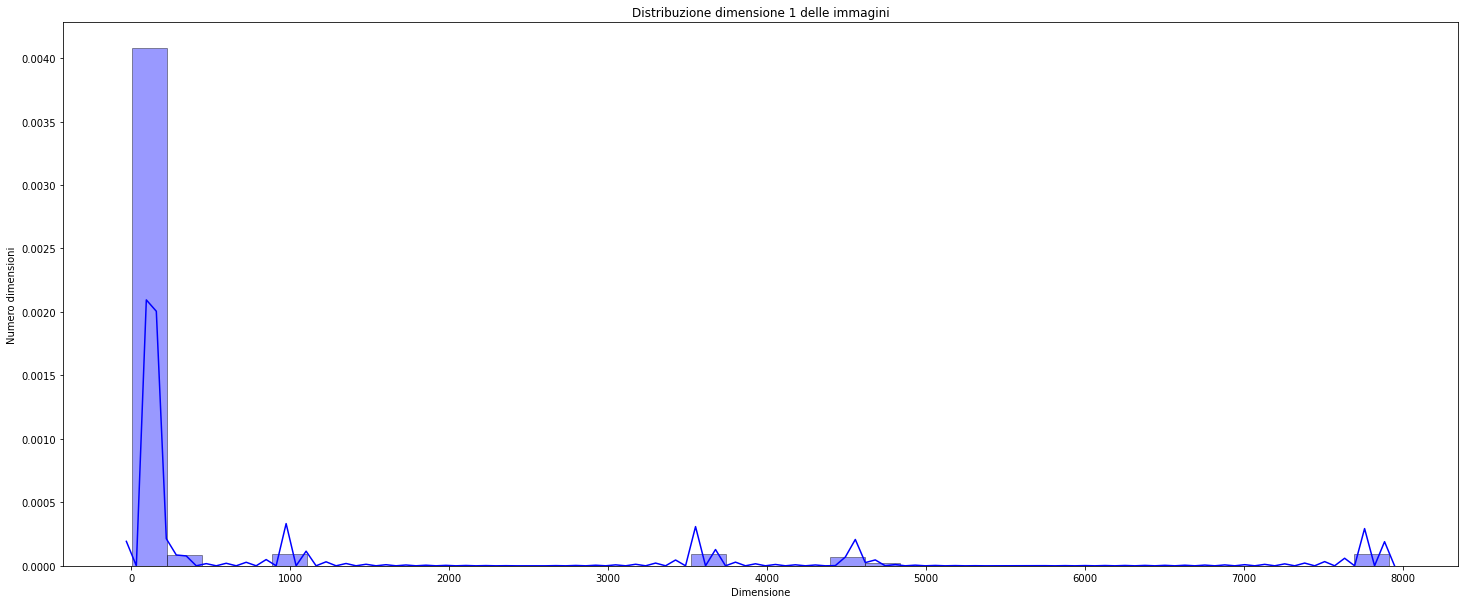

In [28]:
# matplotlib histogram
plt.figure(figsize=(25,10))
#plt.hist(dimensioni, color = 'blue', edgecolor = 'black', bins = int(180/5))

# seaborn histogram
ax = sns.distplot(dimensioni, hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'}
             )
# Add labels
plt.title('Distribuzione dimensione 1 delle immagini')
plt.xlabel("Dimensione") # x label
plt.ylabel("Numero dimensioni") # y label

plt.show()

In [29]:
diz_valori_x_classe = defaultdict(list)
diz_valori_x_obf = defaultdict(list)

for index in range(len(classi)):
  diz_valori_x_classe[classi[index]].append(dimensioni[index])
  diz_valori_x_obf[offuscatori[index]].append(dimensioni[index])

dict_classe_val_medio = dict()
for key in diz_valori_x_classe:
  mean_val = statistics.mean(diz_valori_x_classe[key])
  dict_classe_val_medio.update({key : mean_val})

dict_obf_val_medio = dict()
for key in diz_valori_x_obf:
  mean_val = statistics.mean(diz_valori_x_obf[key])
  dict_obf_val_medio.update({key : mean_val})

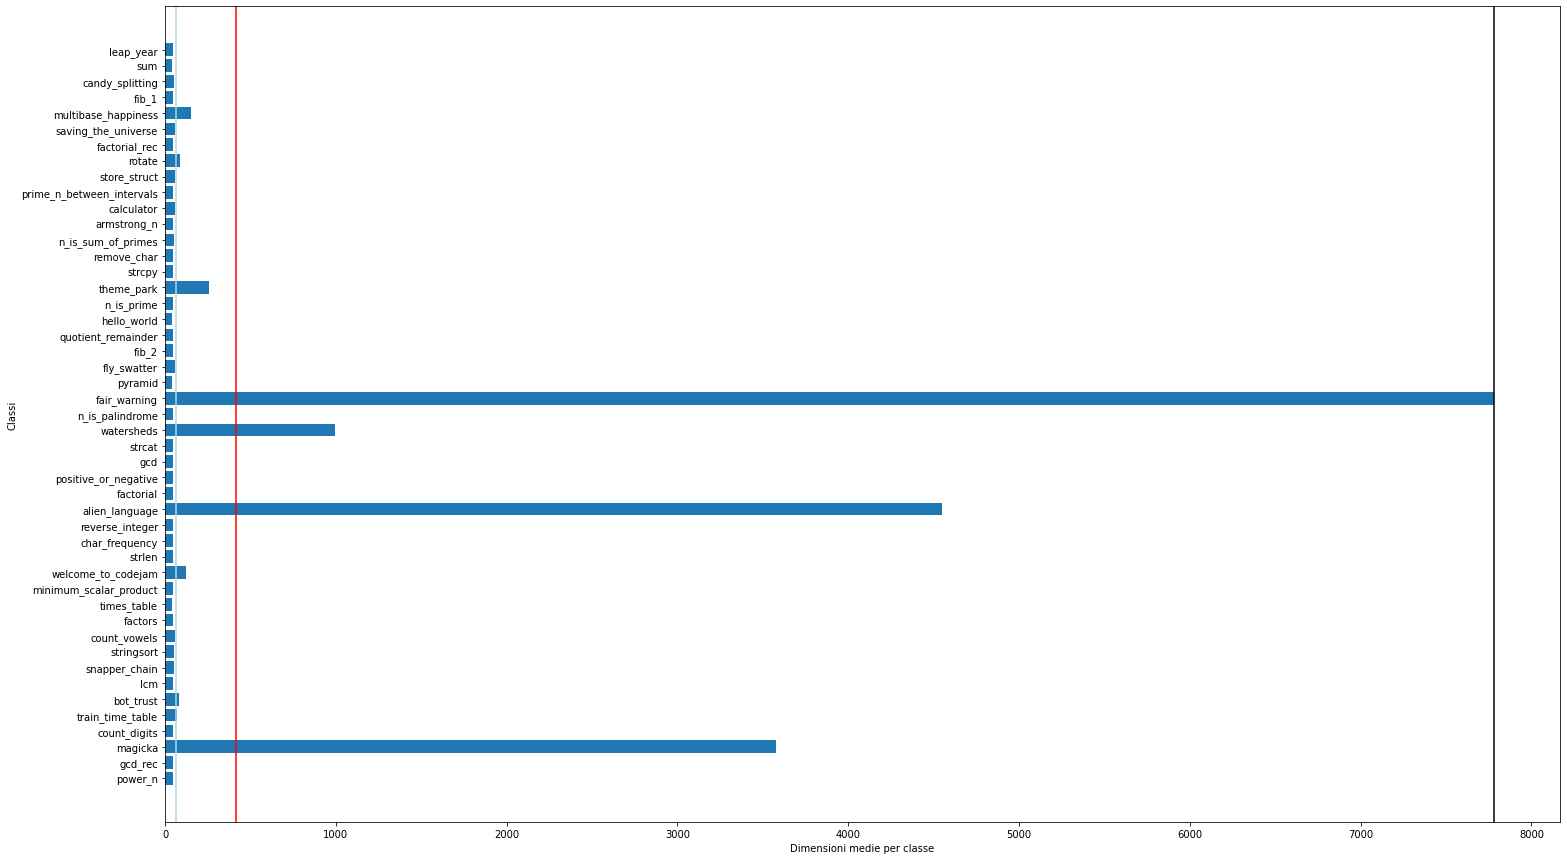

In [30]:
fig = plt.figure(figsize=(25, 15))

plt.barh(list(dict_classe_val_medio.keys()), list(dict_classe_val_medio.values()))

plt.axvline(np.asarray(list(dict_classe_val_medio.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(dict_classe_val_medio.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(dict_classe_val_medio.values())).max(), color="black") # Horizontal line adding the threshold
plt.axvline(64, color="lightblue") # Horizontal line adding the threshold

plt.xlabel("Dimensioni medie per classe") # x label
plt.ylabel("Classi") # y label
plt.show()

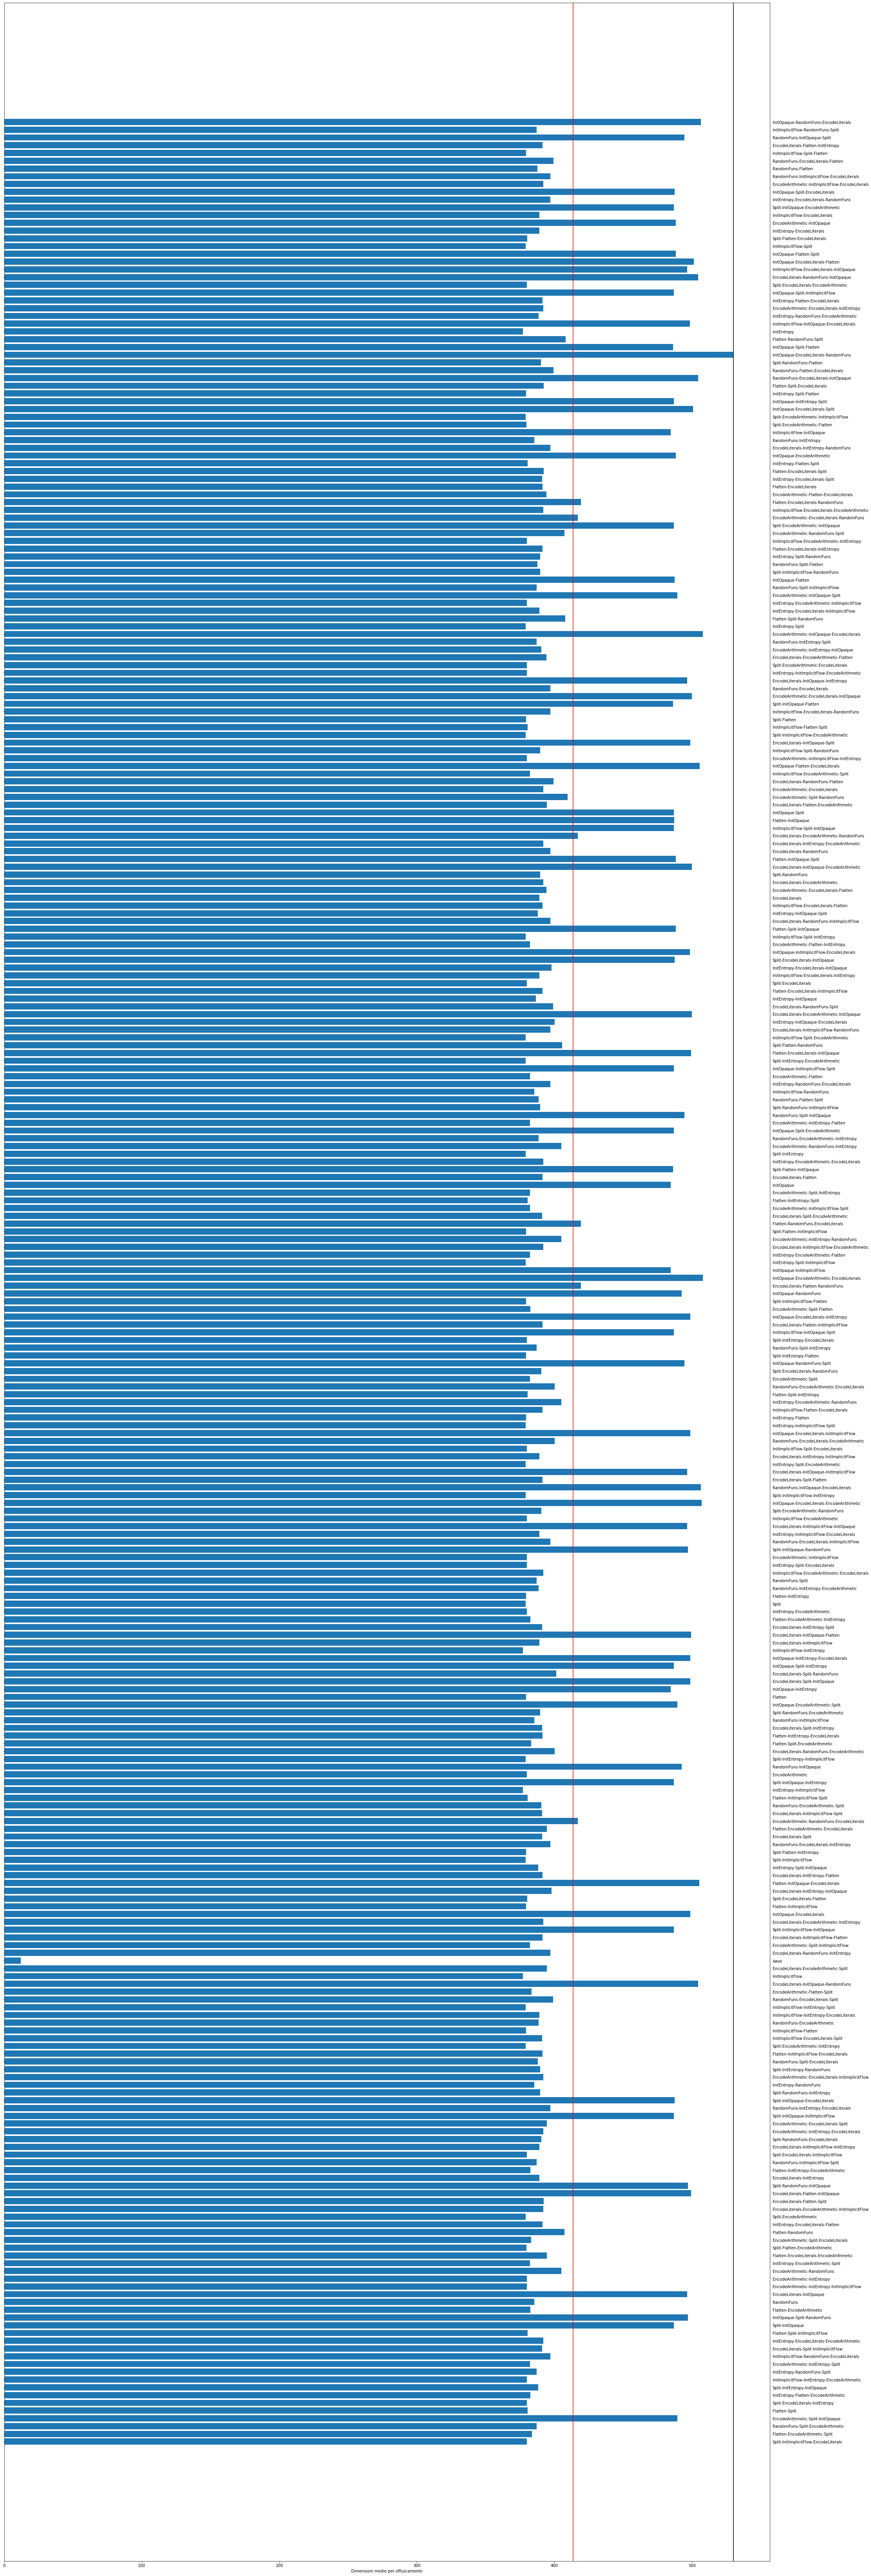

In [31]:
fig = plt.figure(figsize=(35, 120))

plt.barh(list(dict_obf_val_medio.keys()), list(dict_obf_val_medio.values()))

plt.axvline(np.asarray(list(dict_obf_val_medio.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(dict_obf_val_medio.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(dict_obf_val_medio.values())).max(), color="black") # Horizontal line adding the threshold

# move ticks
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)

# move label
plt.ylabel('', labelpad=-725, fontsize=18)
plt.xlabel("Dimensioni medie per offuscamento") # x label
#plt.ylabel("Offuscamento") # y label
plt.show()

In [32]:
lungo = "fair_warning"
corto = "power_n"
obf_val_lungo = defaultdict(list)
obf_val_corto = defaultdict(list)

for index in range(len(classi)):
  if classi[index] == lungo:
    obf_val_lungo[offuscatori[index]].append(dimensioni[index])

  elif classi[index] == corto:
    obf_val_corto[offuscatori[index]].append(dimensioni[index])

obf_val_lungo_medio = dict()
obf_val_corto_medio = dict()

for key in obf_val_lungo:
  mean_val = statistics.mean(obf_val_lungo[key])
  obf_val_lungo_medio.update({key : mean_val})

for key in obf_val_corto:
  mean_val = statistics.mean(obf_val_corto[key])
  obf_val_corto_medio.update({key : mean_val})

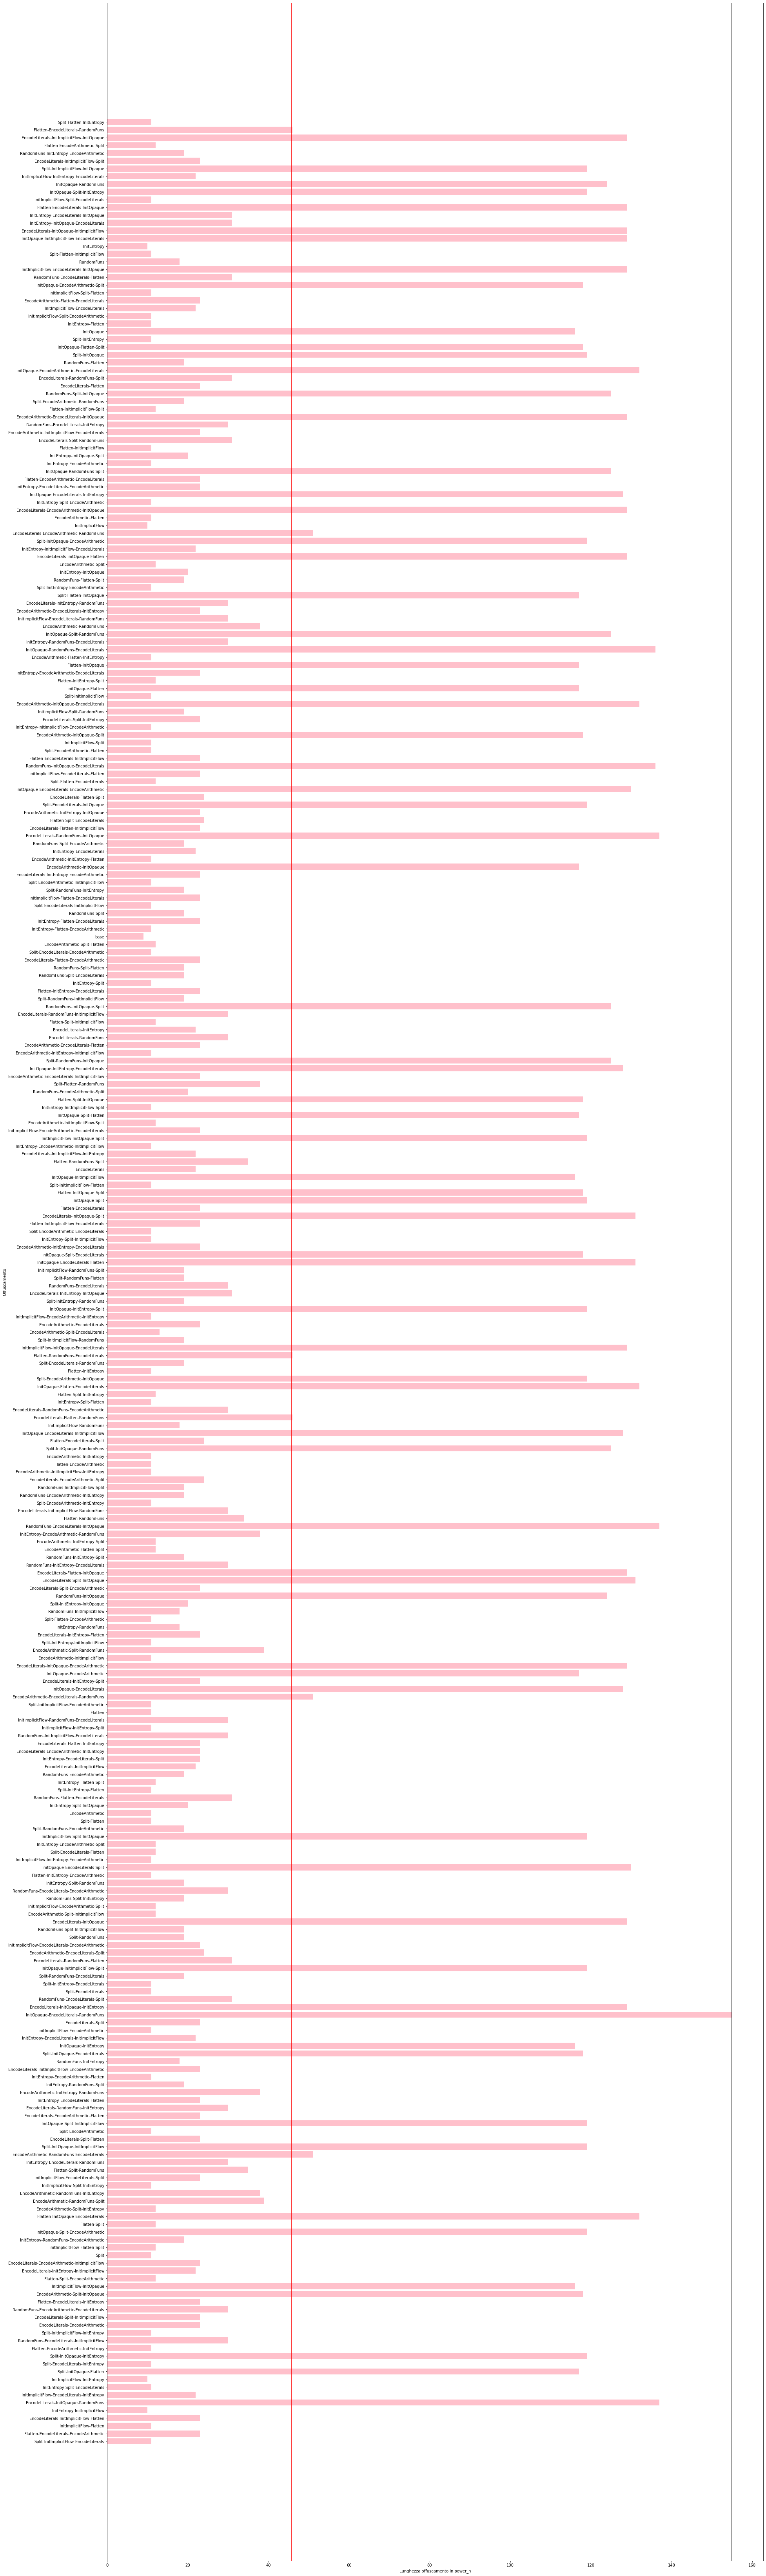

In [33]:
fig = plt.figure(figsize=(30, 120))

plt.barh(list(obf_val_corto_medio.keys()), list(obf_val_corto_medio.values()), color="pink")

plt.axvline(np.asarray(list(obf_val_corto_medio.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(obf_val_corto_medio.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(obf_val_corto_medio.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Lunghezza offuscamento in power_n") # x label
plt.ylabel("Offuscamento") # y label
plt.show()

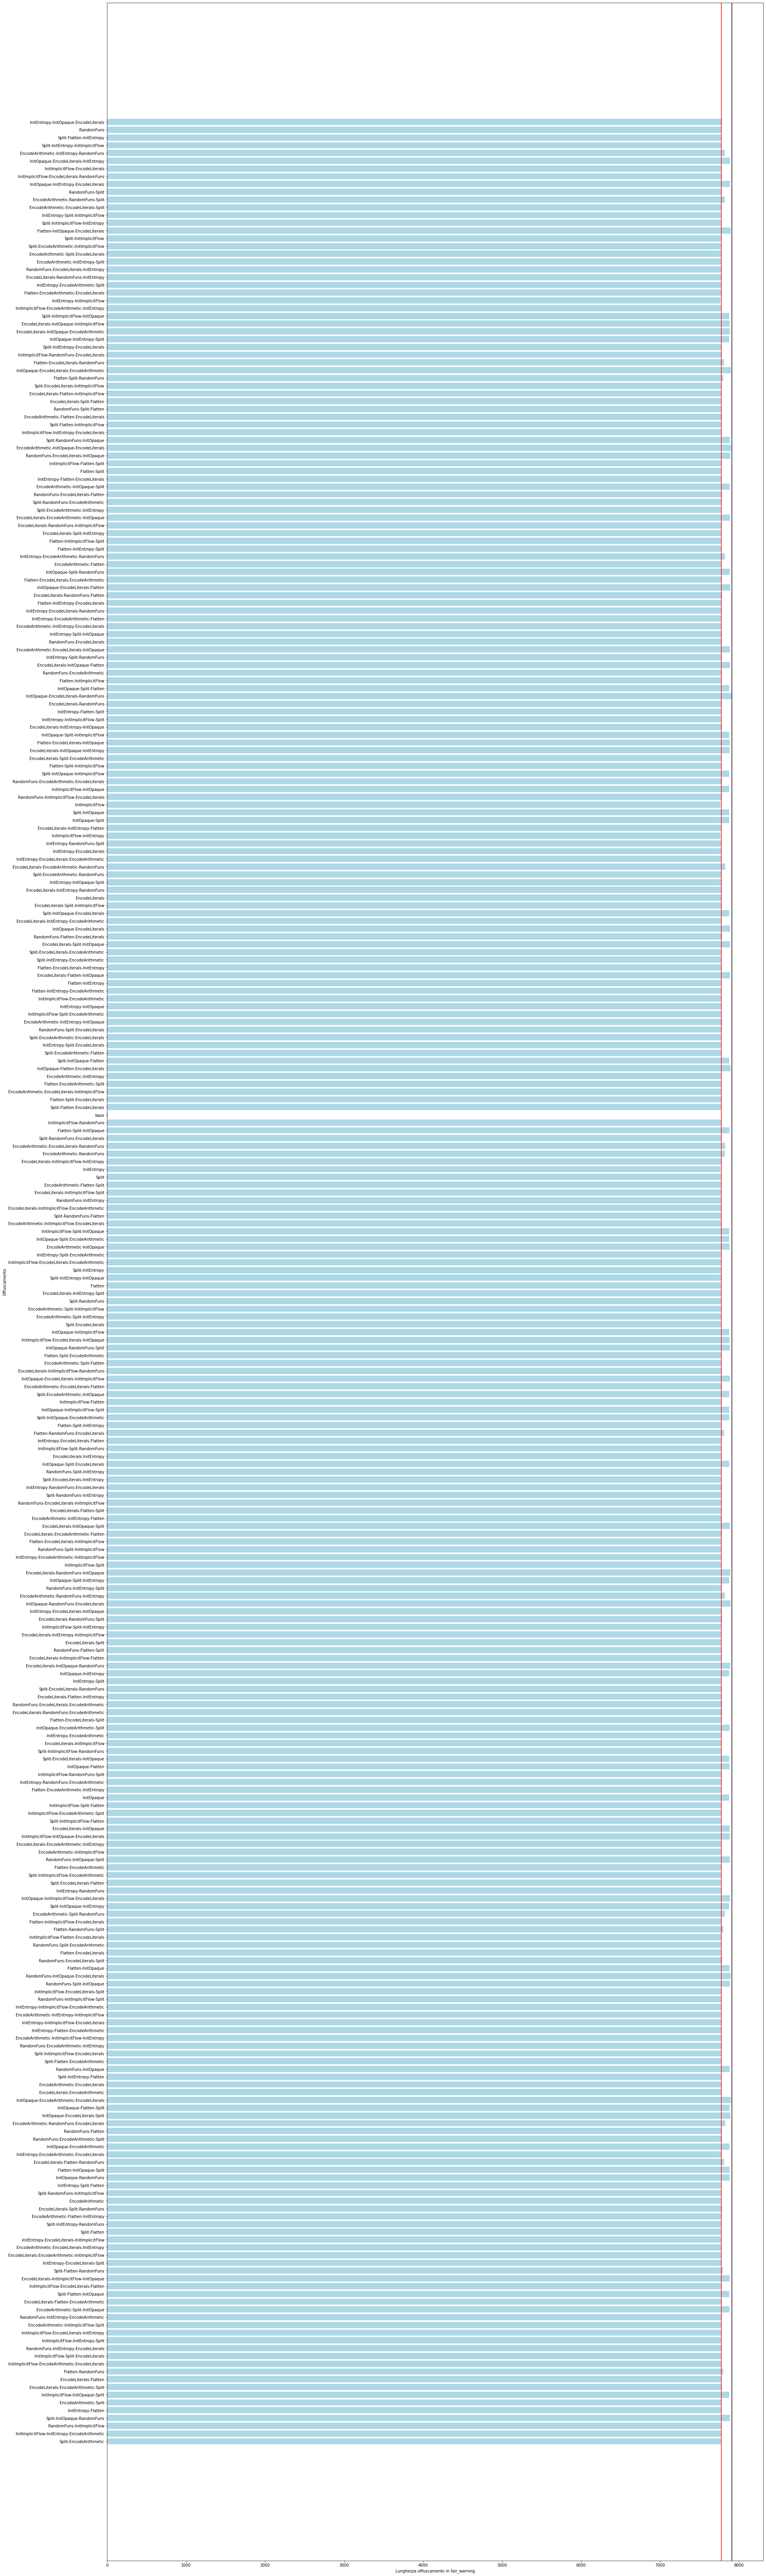

In [34]:
fig = plt.figure(figsize=(30, 120))

plt.barh(list(obf_val_lungo_medio.keys()), list(obf_val_lungo_medio.values()), color="lightblue")

plt.axvline(np.asarray(list(obf_val_lungo_medio.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(obf_val_lungo_medio.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(obf_val_lungo_medio.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Lunghezza offuscamento in fair_warning") # x label
plt.ylabel("Offuscamento") # y label
plt.show()